## Covariance Estimators

In [35]:
import os
import glob
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [140]:
import itertools

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import pandas as pd
import seaborn as sns

from cvtk.cov import temporal_cov
from cvtk.wfsim import wright_fisher, wright_fisher_sample, sample_depth

In [37]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.figsize'] = (16.0, 8.0)
mpl.rcParams['figure.dpi'] = 200
#plt.style.use('buffalo.mplstyle')

In [234]:
np.random.seed(0)
pop_freqs = wright_fisher(10000, 2000, 60, swap=False)
0.5 / np.diag(temporal_cov(pop_freqs, center=False)).mean()

9959.903550297506

In [236]:
counts, depth = sample_depth(pop_freqs, depth=50, diploids=100, poisson=True)
freqs = counts / depth

#0.5 / np.diag(tempcov(freqs, depth,  weighted=True, center=False)).mean()
0.5/np.diag(temporal_cov(freqs, depth, diploids=100, weighted=False, center=True), k=0).mean()

-2564.817615778365

In [133]:
0.5 / np.diag(temporal_cov(pop_freqs, N=1000, weighted=False, center=True)).mean()

476.1113528947312

### Tests

In [231]:
def param_grid(**params):
    keys, values = zip(*params.items())
    return [dict(zip(keys, vals)) for vals in itertools.product(*values)]

def mean_diag(covs, k=0):
    return np.nanmean(np.diag(covs, k=k))

grid = param_grid(N=[100, 1000, 10e3, 10e4], 
                  L=[500, 1000, 2000],
                  ngens=[10], 
                  depth=[20, 50, 100, 500], 
                  #diploids=[0],
                  rep=range(100), 
                  poisson=[False],
                  weighted=[False],
                  center=[True])

for params in grid:
    if params['weighted'] and params['center']:
        # not feasible combination, ignore
        continue
    freqs, sample_freqs, counts, depth = wright_fisher_sample(**params)
    #diploids = params['diploids'] if params['diploids'] != 0 else None
    sample_covmat = temporal_cov(sample_freqs, depths=depth, diploids=None, weighted=params['weighted'], center=params['center'])
    covmat = temporal_cov(freqs, center=params['center'])
    #params['sample_freqs'] = sample_freqs
    #params['counts'] = counts
    #params['depth'] = depth
    params['covmat'] = covmat
    params['sample_covmat'] = sample_covmat
    params['uncorrected_sample_covmat'] = np.cov(cov.calc_deltas(sample_freqs[np.newaxis, ...])[0, ...])
    params['offdiag'] = np.nanmean(np.diag(covmat, k=1))
    params['diag'] = np.nanmean(np.diag(covmat))
    params['sample_offdiag'] = np.nanmean(np.diag(sample_covmat, k=1))
    params['sample_diag'] = np.nanmean(np.diag(sample_covmat))

In [199]:
stats = pd.DataFrame(grid)
#res = stats.groupby(['L', 'N', 'center', 'depth', 'ngens', 'poisson', 'diploids', 'weighted']).mean().reset_index()

/Users/vinceb/miniconda3/envs/basesci/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


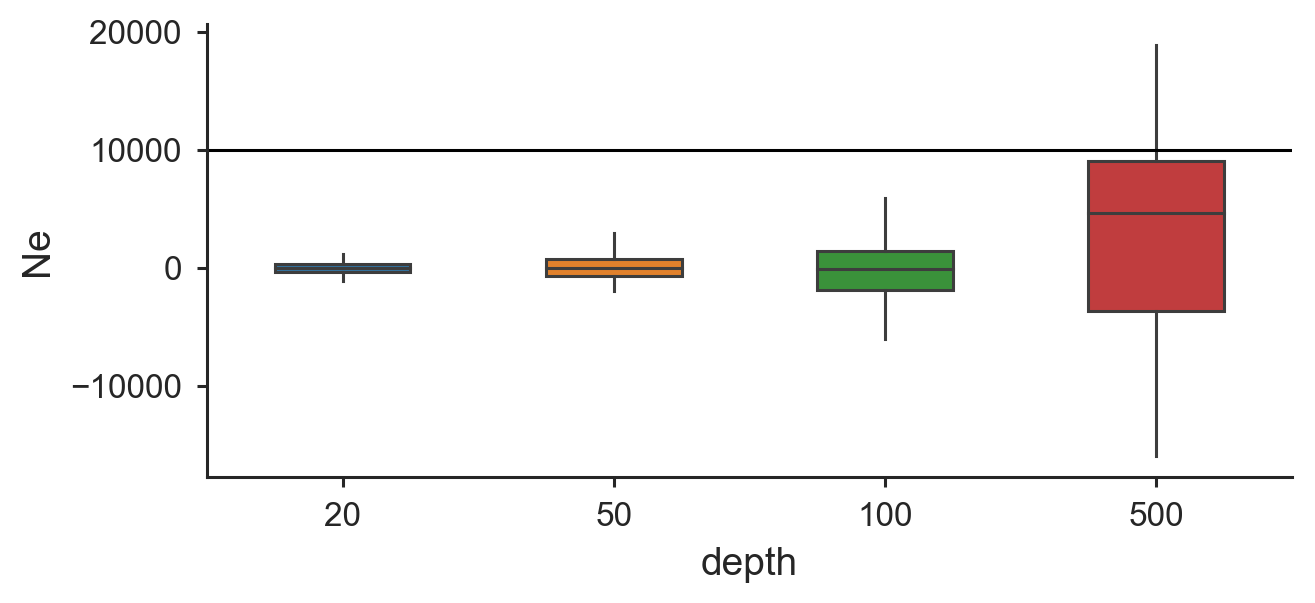

In [239]:
plt.style.use('buffalo.mplstyle')
N =10e3
fig, ax = plt.subplots(figsize=(7, 3))
d = stats.loc[(stats['L'] == 2000) & (stats['N'] == N)]
d['Ne'] = 0.5 / d[['sample_diag']].values
sns.boxplot(x='depth', y='Ne', data=d, width=.5)
plt.axhline(N, c='k')

/Users/vinceb/miniconda3/envs/basesci/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


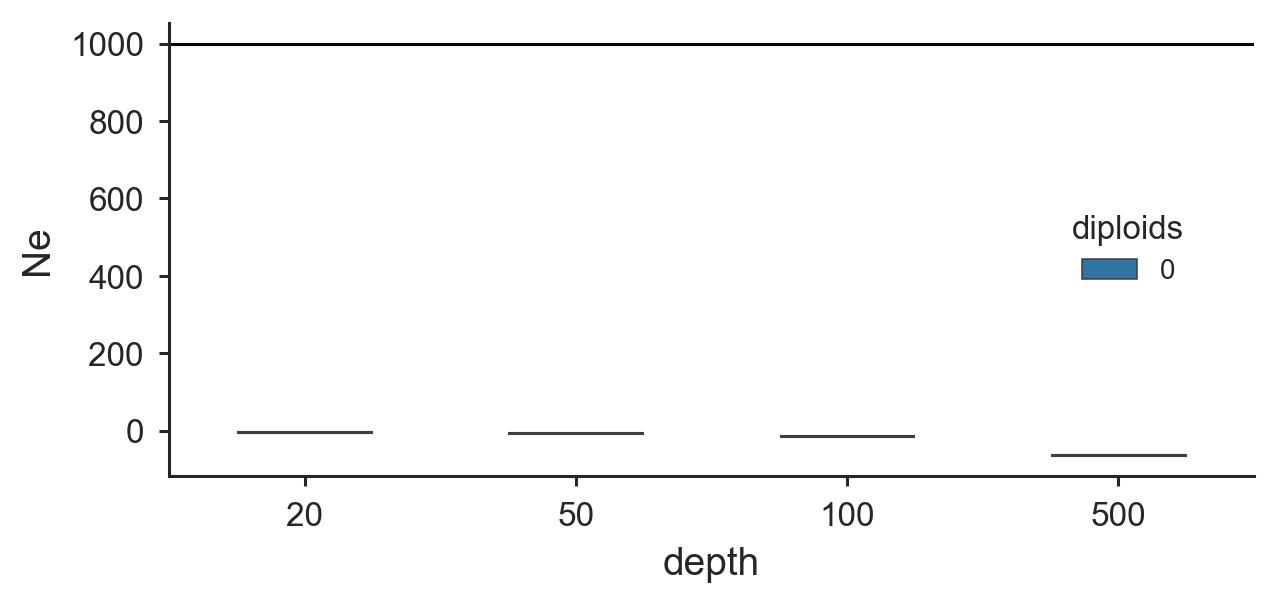

In [127]:
plt.style.use('buffalo.mplstyle')

fig, ax = plt.subplots(figsize=(7, 3))
d = stats.loc[(stats['L'] == 2000) & (stats['N'] == 1000) & (stats['poisson']) & (~stats['weighted']) & (stats['diploids'] == 0)]
d['Ne'] = 0.5 / d[['sample_diag']].values
sns.boxplot(x='depth', y='Ne', hue='diploids', data=d, width=.5)
plt.axhline(1000, c='k')

ValueError: Could not interpret input 'diag_bias'

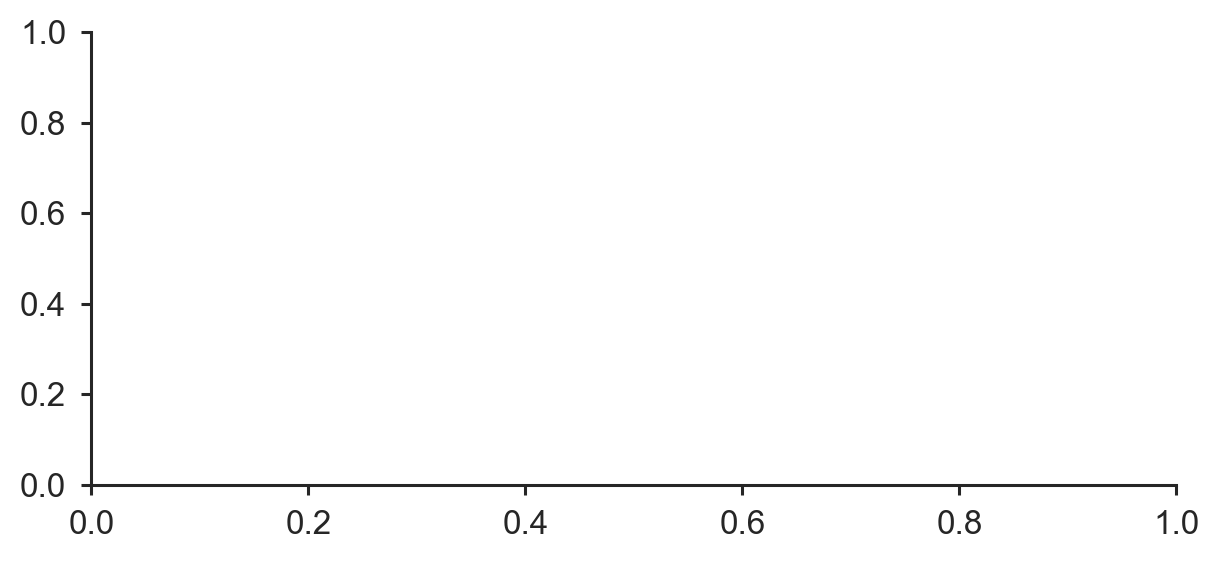

In [74]:
plt.style.use('buffalo.mplstyle')

fig, ax = plt.subplots(figsize=(7, 3))
d = stats.loc[(stats['L'] == 500) & (stats['N'] == 1000) & (stats['poisson']) & (~stats['weighted']) & (stats['diploids'] == 0)]
#g = sns.FacetGrid(d, row='diploids')
#g.map(sns.boxplot, x='depth', y='diag_bias')
sns.boxplot(x='depth', y='diag_bias', hue='center', data=d, width=.5)
#plt.boxplot()
plt.axhline(0, c='k')

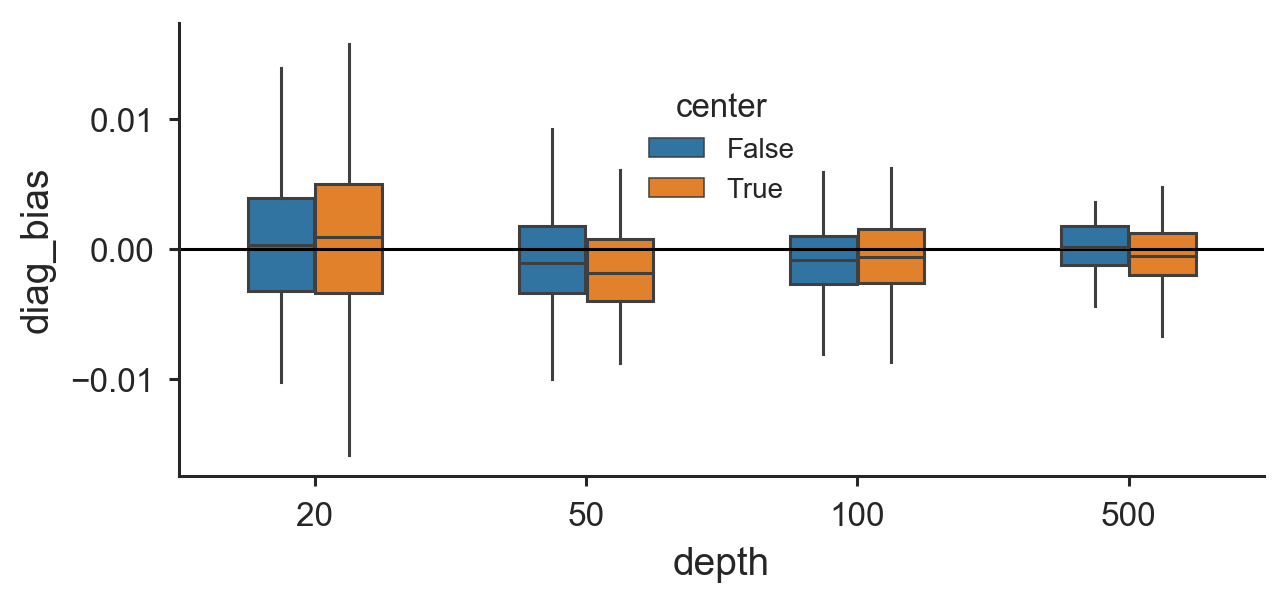

In [44]:
fig, ax = plt.subplots(figsize=(7, 3))
d = stats.loc[(stats['L'] == 500) & (stats['N'] == 1000) & (stats['poisson']) & (~stats['weighted']) & (stats['diploids'] == 10)]
#g = sns.FacetGrid(d, row='diploids')
#g.map(sns.boxplot, x='depth', y='diag_bias')
sns.boxplot(x='depth', y='diag_bias', hue='center', data=d, width=.5)
#plt.boxplot()
plt.axhline(0, c='k')

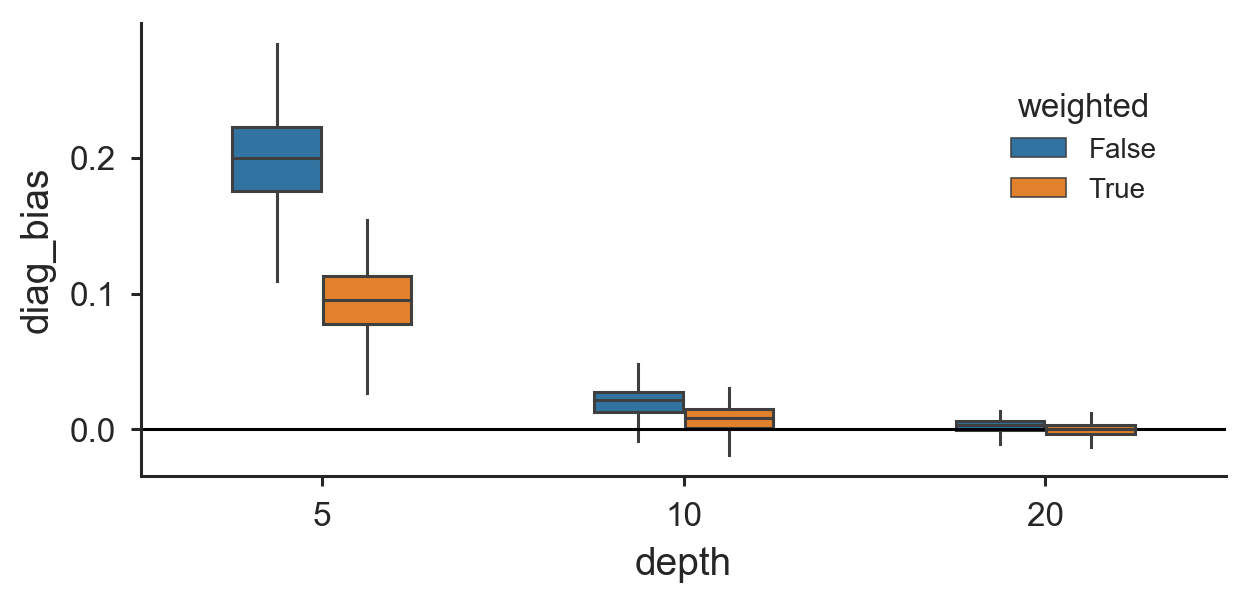

In [21]:
d = stats.loc[(stats['L'] == 500) & (stats['N'] == 1000) & (stats['depth'] <= 20) & (stats['poisson'])]
#g = sns.FacetGrid(d, row='diploids')
#g.map(sns.boxplot, x='depth', y='diag_bias')

fig, ax = plt.subplots(figsize=(7, 3))
sns.boxplot(x='depth', y='diag_bias', hue='weighted', data=d, width=0.5)
plt.axhline(0, c='k')

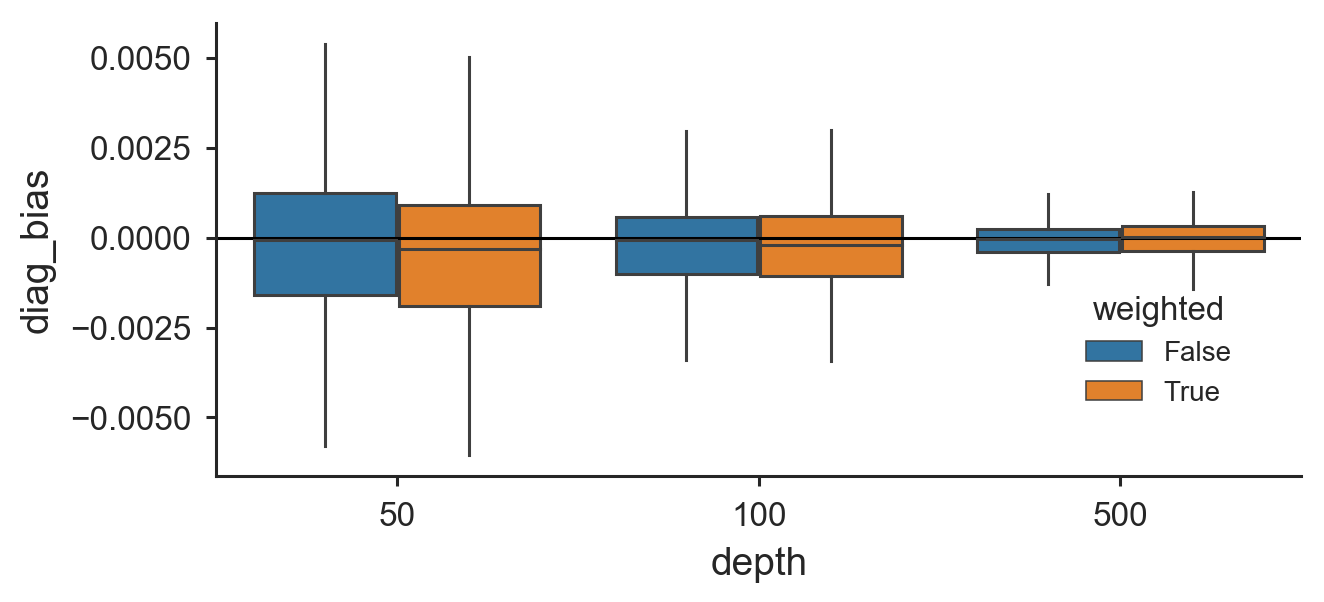

In [22]:

fig, ax = plt.subplots(figsize=(7, 3))
d = stats.loc[(stats['L'] == 500) & (stats['N'] == 1000) & (stats['depth'] > 20) & (stats['poisson'])]
#g = sns.FacetGrid(d, row='diploids')
#g.map(sns.boxplot, x='depth', y='diag_bias')
sns.boxplot(x='depth', y='diag_bias', hue='weighted', data=d)
plt.axhline(0, c='k')